In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


Attempting to load data from: ../features_psd_sleep_edf/SC4171E0_psd.csv
Successfully loaded ../features_psd_sleep_edf/SC4171E0_psd.csv
Shape: (2741, 11)
Columns: ['eeg_delta', 'eeg_theta', 'eeg_alpha', 'eeg_beta', 'eeg_gamma', 'eog_delta', 'eog_theta', 'eog_alpha', 'eog_beta', 'eog_gamma', 'label']
Added 'stage' column based on 'label'.

Generating Plot 1: Band Power Across Epochs...


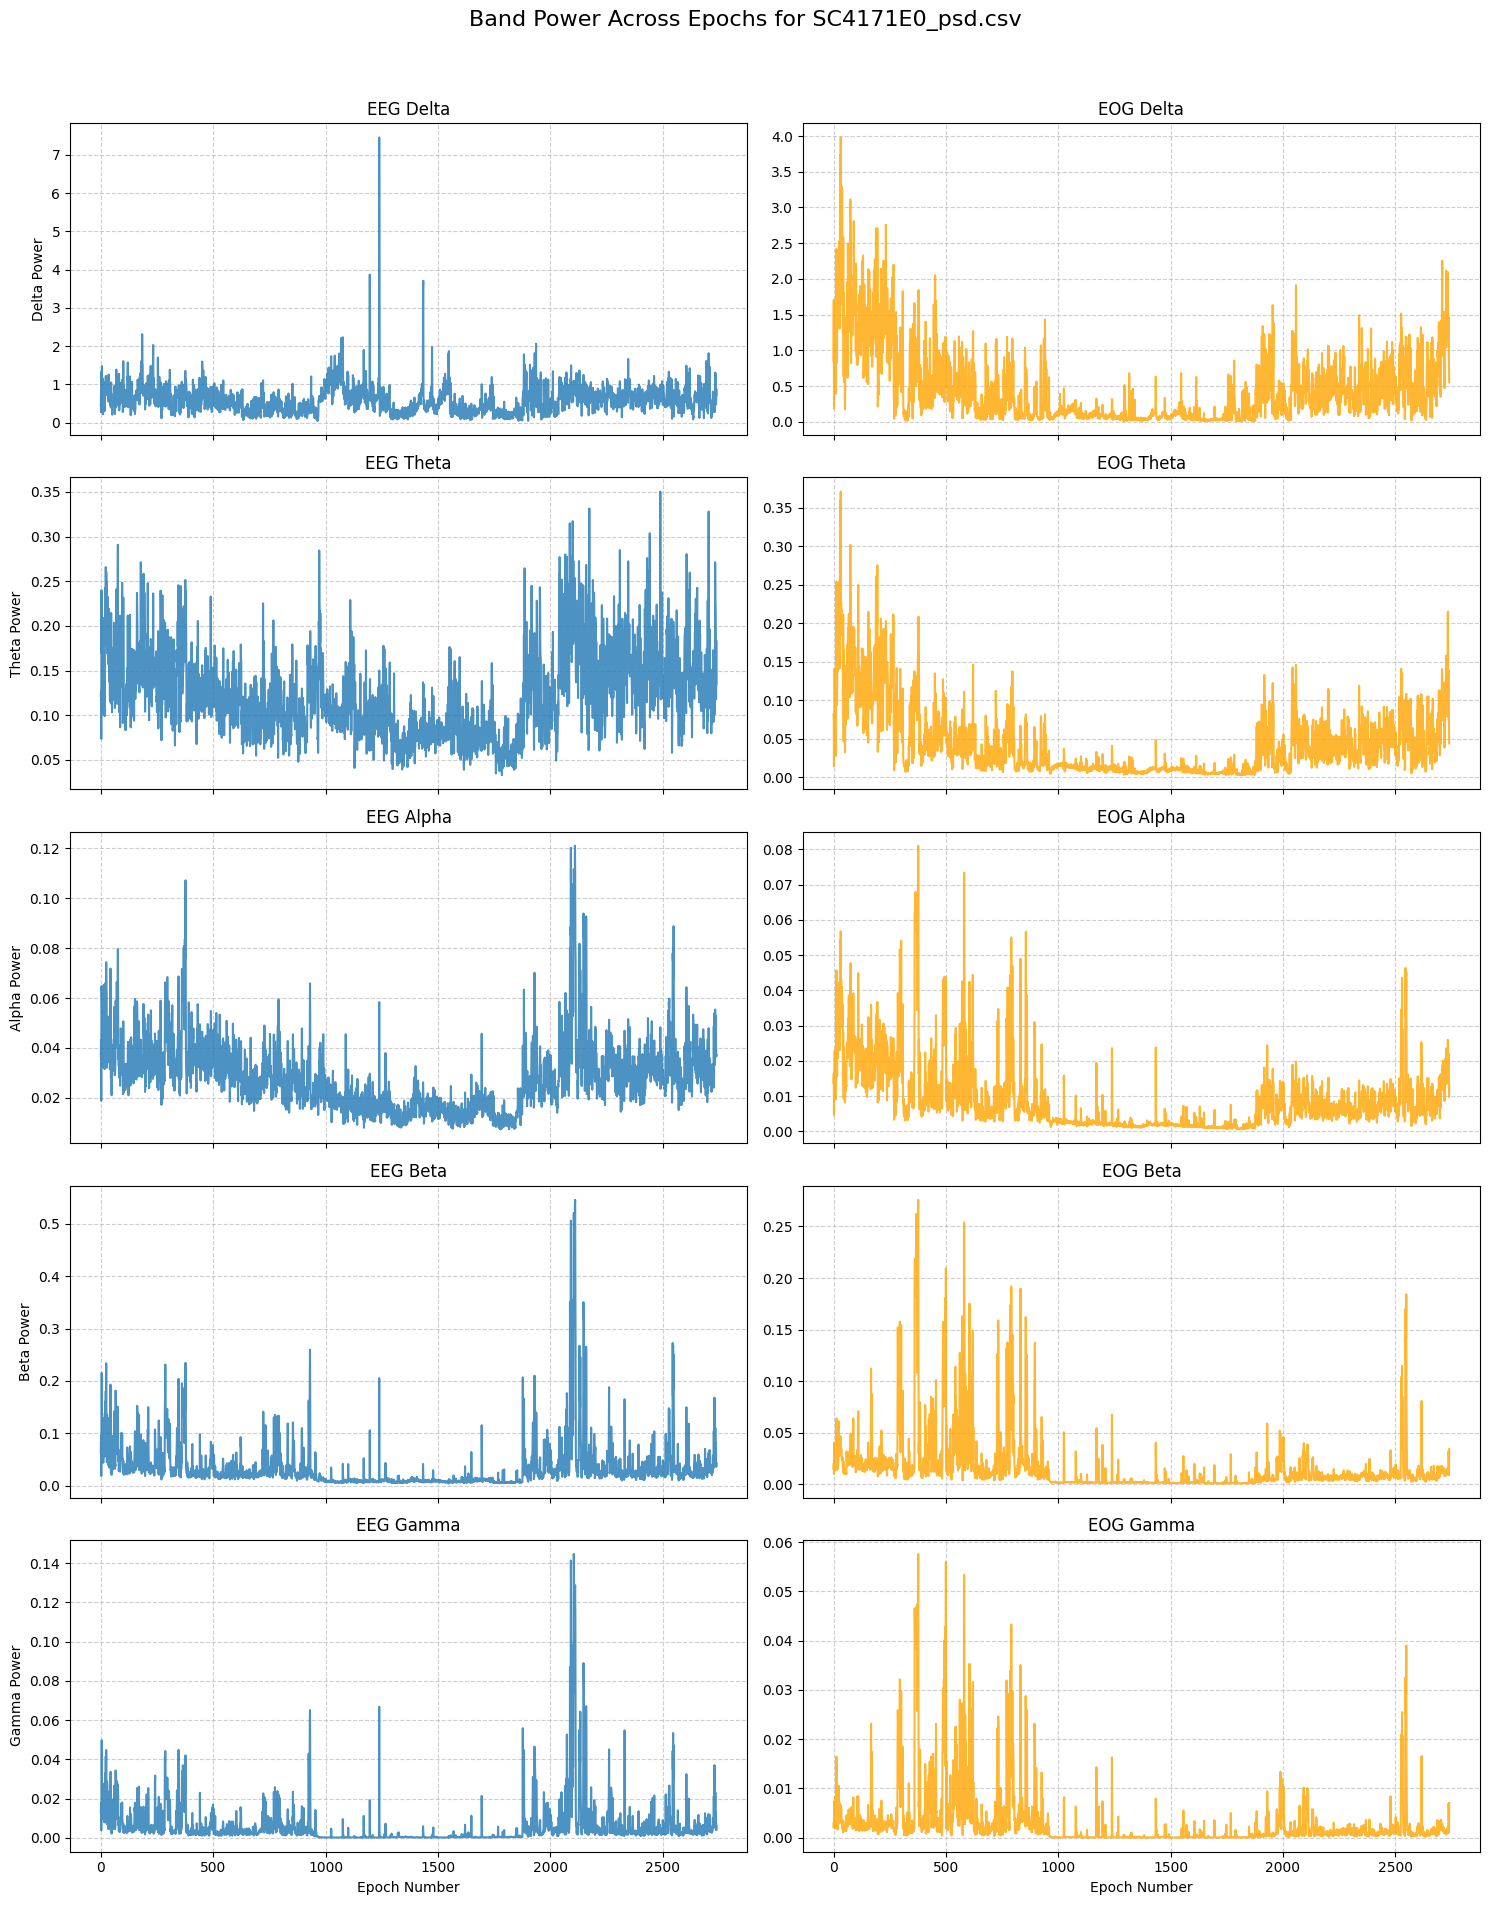


Generating Plot 2: Average Band Power...


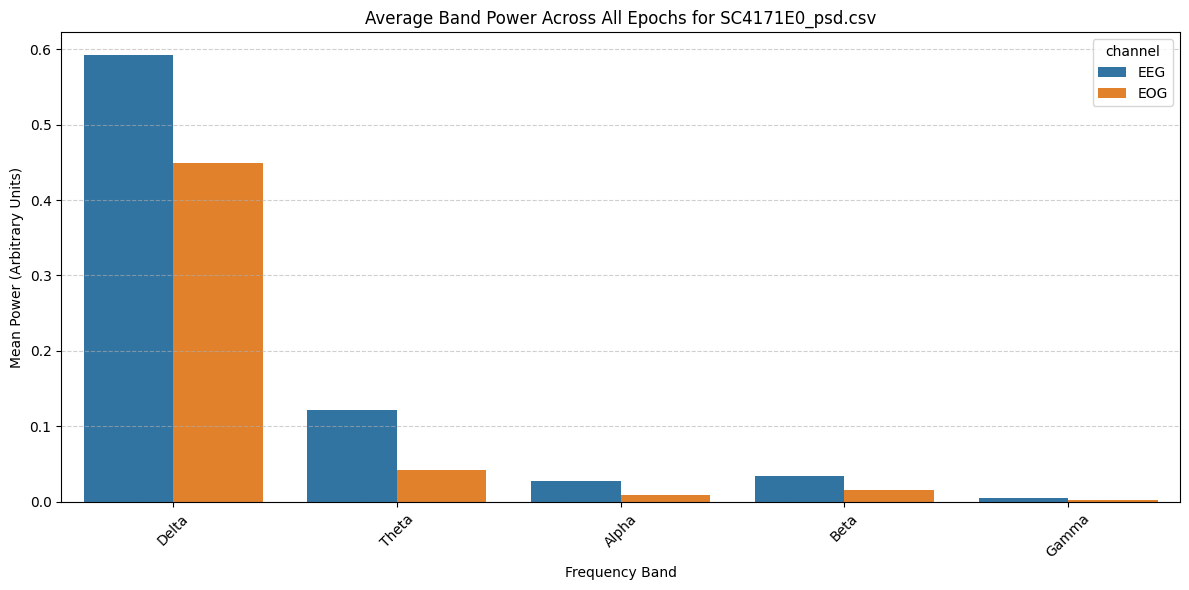


Generating Plot 3: Band Power Distribution by Sleep Stage...


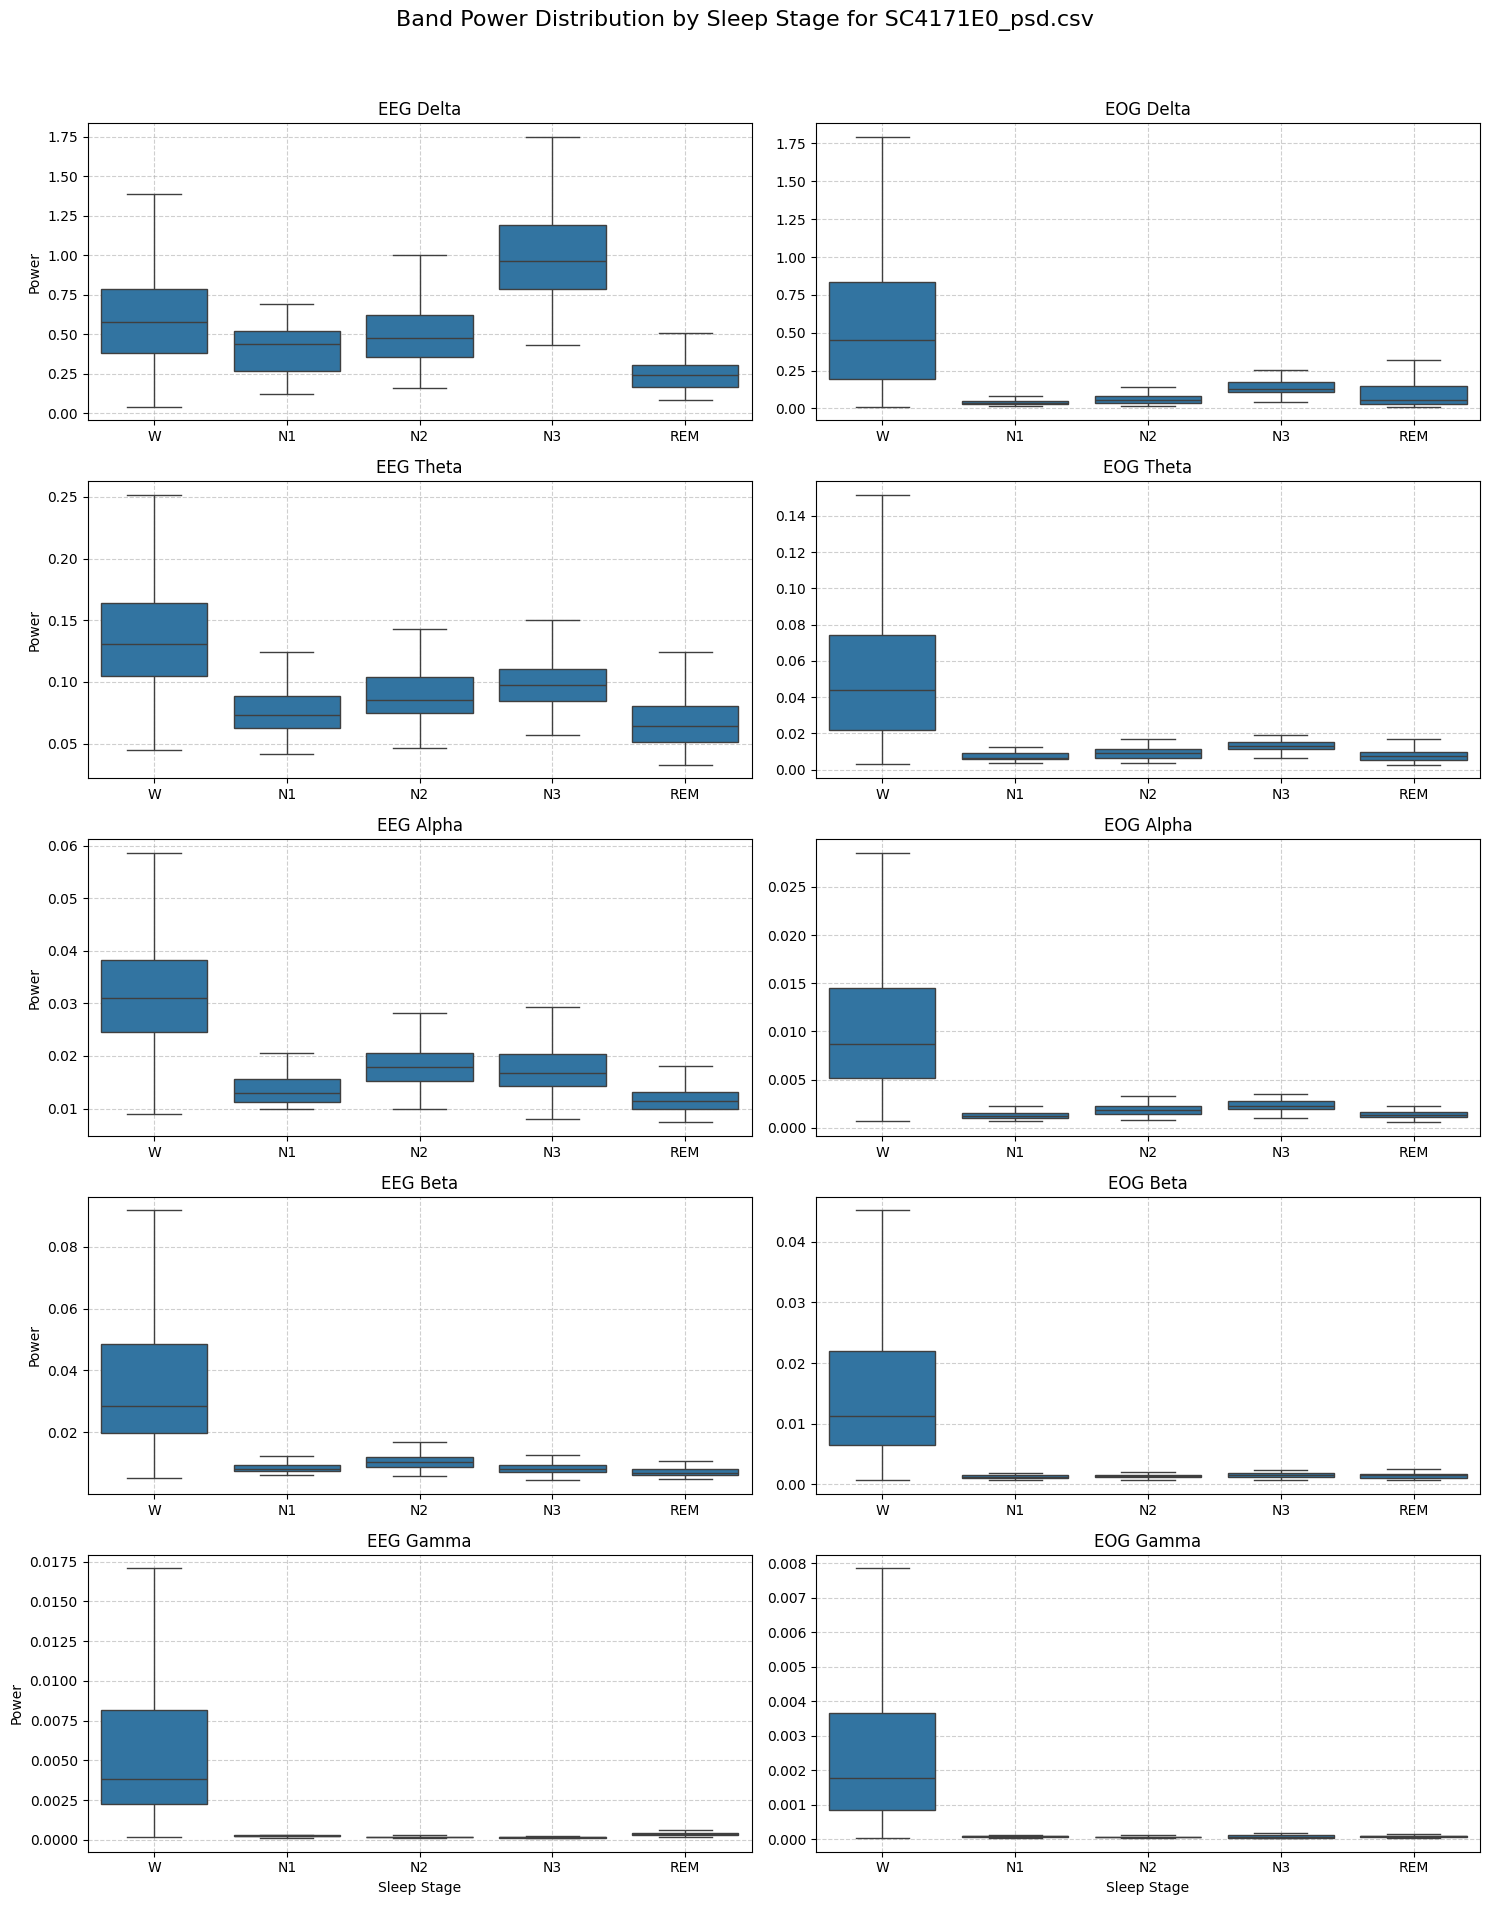


Notebook execution finished.


In [2]:
FEATURES_DIR = '../features_psd_sleep_edf'
FILENAME = 'SC4171E0_psd.csv' # The file selected earlier
FILE_PATH = os.path.join(FEATURES_DIR, FILENAME)

# Define the expected band power feature columns
BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']
CHANNELS = ['eeg', 'eog']
FEATURE_COLUMNS = [f"{ch}_{band}" for ch in CHANNELS for band in BANDS]
LABEL_MAP = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'} # Map labels to names

# --- Load Data ---
print(f"Attempting to load data from: {FILE_PATH}")
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Successfully loaded {FILE_PATH}")
    print(f"Shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    # Map numeric labels to string names for plots
    if 'label' in df.columns:
        df['stage'] = df['label'].map(LABEL_MAP)
        print("Added 'stage' column based on 'label'.")
    else:
        print("Warning: 'label' column not found, cannot create 'stage' column.")
        df['stage'] = None # Set to None if label column is missing
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    print(f"Absolute path checked: {os.path.abspath(FILE_PATH)}")
    print("Please ensure the FEATURES_DIR and FILENAME are correct relative to the notebook location, and the feature extraction script has run.")
    df = None
except Exception as e:
    print(f"An error occurred loading the file: {e}")
    df = None

# %% [markdown]
# ## Plot 1: Band Power Across Epochs
#
# This plot shows how the power in each frequency band changes over the course of the recording for both EEG and EOG channels. This can be quite noisy, especially for longer recordings.

# %%
if df is not None:
    n_epochs = len(df)
    epochs_range = np.arange(n_epochs)

    print("\nGenerating Plot 1: Band Power Across Epochs...")

    n_features = len(FEATURE_COLUMNS)
    n_cols = 2 # Arrange plots in 2 columns (EEG, EOG)
    n_rows = len(BANDS)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True)
    # Adjust title position if needed
    fig.suptitle(f'Band Power Across Epochs for {FILENAME}', fontsize=16)

    plot_created = False
    for i, band in enumerate(BANDS):
        eeg_col = f'eeg_{band}'
        eog_col = f'eog_{band}'

        # Determine correct axes index for single vs multiple rows
        ax_eeg = axes[i, 0] if n_rows > 1 else axes[0]
        ax_eog = axes[i, 1] if n_rows > 1 else axes[1]

        # Check if columns exist before plotting
        if eeg_col in df.columns:
            ax_eeg.plot(epochs_range, df[eeg_col], label=eeg_col, alpha=0.8)
            ax_eeg.set_ylabel(f'{band.capitalize()} Power')
            ax_eeg.set_title(f'EEG {band.capitalize()}')
            ax_eeg.grid(True, linestyle='--', alpha=0.6)
            plot_created = True

        if eog_col in df.columns:
            ax_eog.plot(epochs_range, df[eog_col], label=eog_col, alpha=0.8, color='orange')
            ax_eog.set_title(f'EOG {band.capitalize()}')
            ax_eog.grid(True, linestyle='--', alpha=0.6)
            plot_created = True

    if plot_created:
        # Set common X label only if plots were made
        (axes[n_rows-1, 0] if n_rows > 1 else axes[0]).set_xlabel('Epoch Number')
        (axes[n_rows-1, 1] if n_rows > 1 else axes[1]).set_xlabel('Epoch Number')

        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout rect to make space for suptitle
        plt.show()
    else:
        print("Could not create Plot 1 because necessary feature columns were not found.")
else:
    print("DataFrame not loaded. Cannot create Plot 1.")

# %% [markdown]
# ## Plot 2: Average Band Power
#
# This plot shows the mean power value for each frequency band, averaged across all epochs in the recording. It provides a summary of the overall spectral content.

# %%
if df is not None:
    print("\nGenerating Plot 2: Average Band Power...")
    # Ensure feature columns exist before calculating mean
    valid_feature_cols = [col for col in FEATURE_COLUMNS if col in df.columns]
    if not valid_feature_cols:
        print("Could not create Plot 2: No valid feature columns found in the DataFrame.")
    else:
        # Calculate mean power for existing feature columns
        mean_powers = df[valid_feature_cols].mean().reset_index()
        mean_powers.columns = ['feature', 'mean_power']

        # Separate channel and band for easier plotting
        mean_powers['channel'] = mean_powers['feature'].apply(lambda x: x.split('_')[0].upper())
        mean_powers['band'] = mean_powers['feature'].apply(lambda x: x.split('_')[1].capitalize())

        # Sort bands for consistent plotting order
        band_order = [b.capitalize() for b in BANDS]
        mean_powers['band'] = pd.Categorical(mean_powers['band'], categories=band_order, ordered=True)
        mean_powers = mean_powers.sort_values(['channel', 'band'])

        plt.figure(figsize=(12, 6))
        sns.barplot(data=mean_powers, x='band', y='mean_power', hue='channel')
        plt.title(f'Average Band Power Across All Epochs for {FILENAME}')
        plt.xlabel('Frequency Band')
        plt.ylabel('Mean Power (Arbitrary Units)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
else:
    print("DataFrame not loaded. Cannot create Plot 2.")


# %% [markdown]
# ## Plot 3: Band Power Distribution by Sleep Stage
#
# These box plots show the distribution of power within each band for each sleep stage. This helps visualize how spectral content differs between stages.

# %%
if df is not None and 'stage' in df.columns and df['stage'].notna().any():
    print("\nGenerating Plot 3: Band Power Distribution by Sleep Stage...")
    n_features = len(FEATURE_COLUMNS)
    n_cols = 2 # EEG / EOG
    n_rows = len(BANDS)
    # Use stages present in the data, ordered W, N1, N2, N3, REM if possible
    stages_present = df['stage'].unique()
    # Filter LABEL_MAP based on stages actually present and then sort
    ordered_keys = sorted([k for k, v in LABEL_MAP.items() if v in stages_present])
    stage_order = [LABEL_MAP[k] for k in ordered_keys]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=False) # Share Y axis might compress some plots too much
    fig.suptitle(f'Band Power Distribution by Sleep Stage for {FILENAME}', fontsize=16)

    plot_created = False
    for i, band in enumerate(BANDS):
        eeg_col = f'eeg_{band}'
        eog_col = f'eog_{band}'

        # Determine correct axes index for single vs multiple rows
        ax_eeg = axes[i, 0] if n_rows > 1 else axes[0]
        ax_eog = axes[i, 1] if n_rows > 1 else axes[1]

        # EEG Plot
        if eeg_col in df.columns:
            sns.boxplot(ax=ax_eeg, data=df, x='stage', y=eeg_col, order=stage_order, showfliers=False) # Hide outliers for clarity
            ax_eeg.set_title(f'EEG {band.capitalize()}')
            ax_eeg.set_ylabel('Power')
            ax_eeg.set_xlabel('Sleep Stage' if i == n_rows - 1 else '')
            ax_eeg.grid(True, linestyle='--', alpha=0.6)
            plot_created = True

        # EOG Plot
        if eog_col in df.columns:
            sns.boxplot(ax=ax_eog, data=df, x='stage', y=eog_col, order=stage_order, showfliers=False)
            ax_eog.set_title(f'EOG {band.capitalize()}')
            ax_eog.set_ylabel('') # Y label only on left
            ax_eog.set_xlabel('Sleep Stage' if i == n_rows - 1 else '')
            ax_eog.grid(True, linestyle='--', alpha=0.6)
            plot_created = True

    if plot_created:
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout rect
        plt.show()
    else:
        print("Could not create Plot 3 because necessary feature columns were not found.")

elif df is None:
    print("DataFrame not loaded. Cannot create Plot 3.")
else: # df exists but 'stage' column is missing or has no data
     print("Column 'stage' (derived from 'label') not found or empty in DataFrame. Cannot create Plot 3.")


# %%
print("\nNotebook execution finished.")